In [1]:
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.hysteresis import *


In [2]:
# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )

In [3]:
from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu
from OSCC_postprocessing.filters.bilateral_filter import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [4]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Postprocessing_Py\\.venv\\Lib\\site-packages\\cupy\\__init__.py'>


In [5]:
# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy

from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
from OSCC_postprocessing.binary_ops.masking import * 


In [6]:


def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)


In [286]:

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits
gamma = 1.0

frames_before_SOI = 10

file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T19\1.cine")
# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=80)
# Normalize the grayscale video to [0, 1] brightness range
video = xp.asarray(video)/ brightness_levels

F, H, W = video.shape



if gamma != 1.0:
    video = video ** gamma

json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T1\config.json")
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")



Video Info - Width: 768, Height: 768, Frames: 80
The injector has 10 plumes.
The nozzle is centred at (392.50, 378.37) in image coordinates.


In [330]:
def mie_multihole_video_strip_processing(video,
                                  centre,  
                                  inner_radius, 
                                  outer_radius, 
                                  number_of_plumes, 
                                  init_frames=10, 
                                  ):
    # Shape 
    F, H, W = video.shape
    # Take the filtered first few frames as background 
    bkg = cp.mean(video[:init_frames], axis=0)[None, :, :]

    # subtract background
    # video -= bkg
    
    # Apply ring mask
    ring_mask = generate_ring_mask(H, W, centre, inner_radius, outer_radius, xp)

    # mask the video
    # video *= ring_mask[None, :, :]

    # Sum in all frames
    video_sum_all_frame = _min_max_scale(cp.sum(video, axis=0)*1.0)

    # Make a mask that only leaves area with distinguishable 
    sum_mask = _triangle_binarize_gpu(video_sum_all_frame, ignore_zeros=False)

    # Compute angular signal density
    bins = 720

    scale = bins/360.0

    _, total_angular_signal_density, _ = angle_signal_density_auto(video_sum_all_frame[None, :, :], centre[0], centre[1], N_bins=bins)

    # Finding the best rotation offset
    offset = estimate_offset_from_fft(total_angular_signal_density, number_of_plumes)

    # Angles of the axes at which to be rotated
    angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - _as_numpy(offset)
    
    # Bin-wise mask
    bin_wise_mask = fill_short_false_runs(_triangle_binarize_gpu(cp.sum(total_angular_signal_density, axis=0), ignore_zeros=True), max_len=3)

    occupied_angles = periodic_true_segment_lengths(bin_wise_mask)

    average_occupied_angle = (bin_wise_mask.sum()/bins*360.0/number_of_plumes).item()

    angular_mask = generate_angular_mask_from_tf(H, W, centre, total_angular_signal_density, bins)


    # This is the final mask on the raw image
    # final_mask = (sum_mask * angular_mask[:, :, 0] )
    final_mask = angular_mask[:, :, 0]
    final_mask = (final_mask * ring_mask)

    # Rotation of video strips

    # Allocate collector
    segments = []
    # Arbitrary rotated image strip shape
    OUT_SHAPE = (H // 4, W//2)


    for idx, angle in enumerate(angles):
        segment, _, _ = rotate_video_nozzle_at_0_half_backend(
                video,
                centre, 
                angle,
                interpolation="bilinear",
                border_mode="constant",
                out_shape=OUT_SHAPE,
            )
        segments.append(segment)


    segments = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)
    segments = xp.clip(segments, 0.0, 1.0).astype(xp.float16)


    plume_mask = generate_plume_mask(segments.shape[3], segments.shape[2], angle=average_occupied_angle*1.5, x0=ir_)

    # Rotation of final masks

    # Allocate collector
    segment_masks = []


    for idx, angle in enumerate(angles):
        segment_mask, _, _ = rotate_video_nozzle_at_0_half_backend(
                final_mask[None, :, :],
                centre, 
                angle,
                interpolation="nearest",
                border_mode="constant",
                out_shape=OUT_SHAPE,
            )
        segment_masks.append(segment_mask)


    segment_masks = xp.stack(segment_masks, axis=0)  # (Plume idx, Frame, H, W)

    segment_masks = (segment_masks * xp.asarray(plume_mask[None, None, :, :])).squeeze().astype(bool)

    for (idx, mask) in enumerate(segment_masks):
        segment_masks[idx] = fill_video_holes_gpu(segment_masks[idx])


    return segments, segment_masks>0, occupied_angles, average_occupied_angle


In [2]:

segments, segment_masks, occupied_angles, average_occupied_angle = mie_multihole_video_strip_processing(video,
                                                                                                        centre,  
                                                                                                        ir_, 
                                                                                                        or_, 
                                                                                                        number_of_plumes, 
                                                                                                        init_frames=10, 
                                                                                                        )

P, F, H, W = segments.shape

NameError: name 'mie_multihole_video_strip_processing' is not defined

dtype('bool')

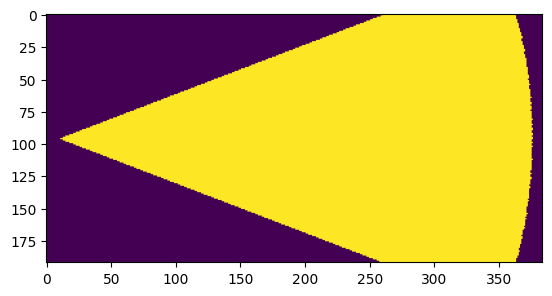

In [332]:
# Verifying the masks
plt.imshow(segment_masks[0].get())

segment_masks.dtype

In [333]:

# play_videos_side_by_side((cp.swapaxes(segments, 2, 3)).get().tolist(), intv=50)
play_videos_side_by_side((cp.swapaxes(segments*(segment_masks[:,None, :,:]), 2, 3)).get().tolist(), intv=50)

In [4]:
from OSCC_postprocessing.filters.convolution_2D_rawKernel import *
ws = 5
sigma = 6
sobel_x = make_kernel("sobel", ws, sigma, direction="x")
sobel_y = make_kernel("sobel", ws, sigma, direction="y")

segments_high_pass = xp.zeros_like(segments)
for p in range(P):
    sb_filt_x = convolution_2D_cupy(segments[p], sobel_x)
    sb_filt_y = convolution_2D_cupy(segments[p], sobel_y)
    segments_high_pass[p] = cp.sqrt(sb_filt_x ** 2 + sb_filt_y ** 2)

    

segments_high_pass -= xp.mean(segments_high_pass[:, :10, :, :], axis=1, keepdims=True)

for p in range(P):
    segments_high_pass[p] = _min_max_scale(cp.clip(segments_high_pass[p], 0, None))


NameError: name 'xp' is not defined

In [366]:

#Testing high pass
play_videos_side_by_side((cp.swapaxes(10.0*segments_high_pass*((segment_masks)[:,None, :,:]), 2, 3)).get().tolist(), intv=50)

In [418]:
# seg_hp_bw = segments_high_pass > 0.3
struct = cp.zeros((3, 3, 3), dtype=bool)
struct[1, :, :] = True

struct2 = cp.ones((3,7,27), dtype=bool)

seg_hp_bw_filled = triangle_binarize_gpu(segments_high_pass) * segment_masks[:, None, :, :]
for p in range(P):

    blob_3D = keep_largest_component_nd_cuda(
        cndi.binary_fill_holes(
            cndi.binary_closing(
                seg_hp_bw_filled[p], structure=struct2
            )
            
            , structure=struct)
        )
    for f in range(F):
        seg_hp_bw_filled[p, f] = keep_largest_component_cuda(blob_3D[f])

In [3]:
play_videos_side_by_side((cp.swapaxes(10.0*seg_hp_bw_filled*((segment_masks)[:,None, :,:]), 2, 3)).get().tolist(), intv=50)

NameError: name 'play_videos_side_by_side' is not defined

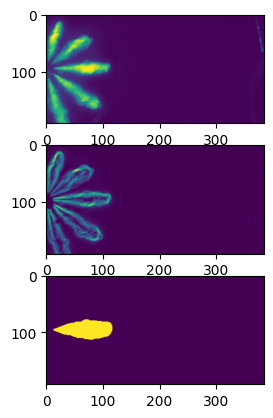

In [420]:
plume_idx = 7
frame_idx = 20

fig, ax = plt.subplots(3,1)
ax[0].imshow(segments[plume_idx, frame_idx].get())
ax[1].imshow(segments_high_pass[plume_idx, frame_idx].get())
ax[2].imshow(seg_hp_bw_filled[plume_idx, frame_idx].get())

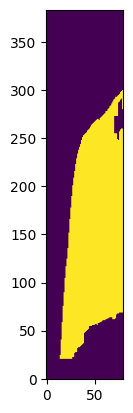

In [421]:
thres = 8
edge_bw_col_sums = xp.sum(seg_hp_bw_filled, axis=2) > thres

pen_edge_bw = xp.swapaxes(edge_bw_col_sums , 1, 2)


plt.imshow(pen_edge_bw[plume_idx].get(), origin="lower")

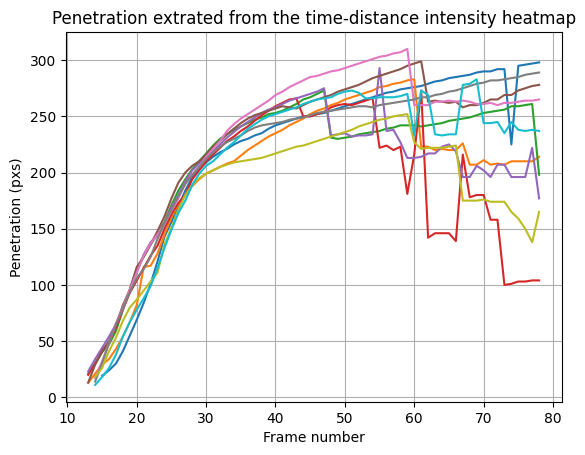

In [ ]:
# penetration_bw_td_T has shape (Plume, Width, Frame)



penetration_highpass = pen_edge_bw.shape[1] - cp.argmax(pen_edge_bw[:, ::-1, :], axis=1)
penetration_highpass = penetration_highpass.astype(cp.float32)  # 或 cp.float64
penetration_highpass[penetration_highpass > or_ ] = cp.nan

# penetration_highpass *= contrast_TF
# penetration_highpass[penetration_highpass==0.0] = cp.nan

plt.plot(penetration_highpass.T.get() - ir_)
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()

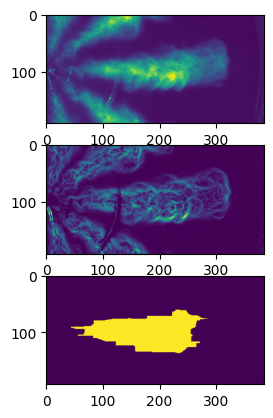

In [440]:
plume_idx = 6
frame_idx = 60

fig, ax = plt.subplots(3,1)
ax[0].imshow(segments[plume_idx, frame_idx].get())
ax[0].axvline(penetration_highpass[plume_idx, frame_idx].get())
ax[1].imshow(segments_high_pass[plume_idx, frame_idx].get())
ax[1].axvline(penetration_highpass[plume_idx, frame_idx].get())
ax[2].imshow(seg_hp_bw_filled[plume_idx, frame_idx].get())
ax[2].axvline(penetration_highpass[plume_idx, frame_idx].get())

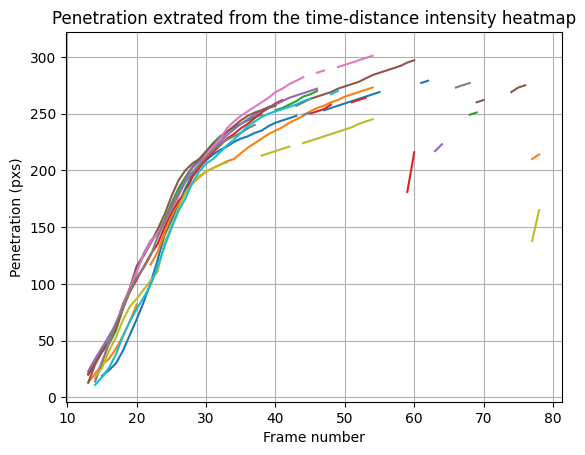

In [425]:
penetration_highpass_diff = xp.diff(penetration_highpass, axis=1)
penetration_highpass[:, :-1][penetration_highpass_diff < 2] = cp.nan

plt.plot(penetration_highpass.T.get() - ir_)
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()

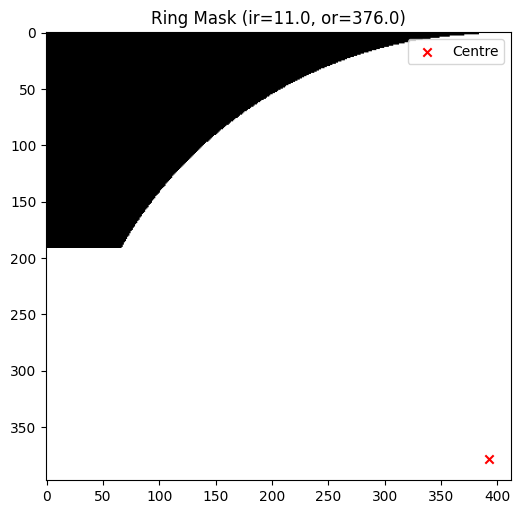

In [224]:

# --- Usage Example ---

# Generate the ring mask
ring_mask = generate_ring_mask(H, W, centre, ir_, or_, xp)

# Visualize the mask
plt.figure(figsize=(6, 6))
plt.imshow(_as_numpy(ring_mask), cmap='gray')
plt.scatter(centre[0], centre[1], c='red', marker='x', label='Centre')
plt.title(f"Ring Mask (ir={ir_}, or={or_})")
plt.legend()
plt.show()


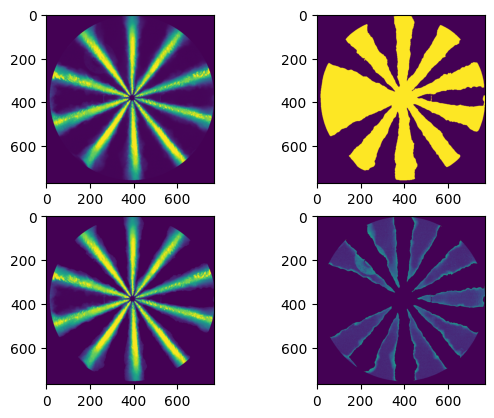

In [225]:
px_range_map = cp.max(video, axis=0) - cp.min(video, axis=0)


range_mask, _ = triangle_binarize_from_float(to_numpy(px_range_map), ignore_zero=True)
# range_mask = keep_largest_component(range_mask)
range_mask = binary_fill_holes(range_mask)
range_mask = cp.asarray(range_mask)


# Visualize max pixel range of each pixel in the video vs the range_mask made out of it
fig, ax = plt.subplots(2,2)

ax[0,0].imshow(_as_numpy(px_range_map))
ax[0,1].imshow(_as_numpy(range_mask))
ax[1,0].imshow(_as_numpy((range_mask*px_range_map)))
ax[1,1].imshow(_as_numpy((px_range_map*(1- range_mask))))
# fig.set_title("Max pixel range of each pixel in the video vs the range_mask made out of it")


In [226]:
# Apply the ring mask

# video *= ()[None, : ,:]

plt.imshow((ring_mask & range_mask).get()) # [None, :, :]

# video *= (ring_mask & range_mask) # [None, :, :]

ValueError: operands could not be broadcast together with shapes (192, 384) (768, 768)

In [ ]:
# pakaged pre-processing calling, use this in real impelmentations
# foreground = pre_processing_mie(video, division=False)

# Explicitly coding for showing the whole process

# We do not divide by the first frame to fix lighting
# In the videos I process, they have some strong bright spots by reflections
# If didivde, they become some dark spots. 


# Bilateral filtering
if use_gpu:
    bilateral_filtered = bilateral_filter_video_cupy(video, 7, 3, 3)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(video), 7, 3, 3)



# Take the filtered first frame as background 
bkg = cp.mean(bilateral_filtered[:frames_before_SOI], axis=0)
bkg[bkg == 0] = 1e-9
bkg[bkg == cp.nan] = 1e-9


# dynamic_bkg = bkg_gain_curve[:, None, None]*(cp.mean(bilateral_filtered[:frames_before_SOI], axis=0)[None, :, :])
bkg = (cp.mean(bilateral_filtered[:frames_before_SOI], axis=0)[None, :, :])

# Foreground is the filtered video - filtered background
foreground = bilateral_filtered - bkg

foreground = cp.clip(foreground, 0, 1) #
# foreground *= mask[None, :, :]


In [ ]:
play = True


In [ ]:
if play:
    # Visualize the filtering results
    # play_video_cv2(video.get())
    play_videos_side_by_side((video.get(), bilateral_filtered.get(), foreground.get()), intv=100) # type: ignore


In [ ]:
plt.title("Background being subtrated, we assume lighting is fixed in the video")
plt.imshow(_as_numpy(bkg).squeeze(), cmap="jet")
plt.colorbar()

In [ ]:
r = or_

# Displaying the clibration
plt.imshow(video[0].get()**0.5, cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

theta = np.linspace(0, 2*np.pi, 400)

x0, y0 = centre[0] , centre[1]

x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

plt.plot(x, y, linewidth="0.5")
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([centre[0]-1.1*r, centre[0]+1.1*r])
plt.ylim([centre[1]-1.1*r, centre[1]+1.1*r])
plt.title("Calibrated centre of the nozzle centre")
centre

In [ ]:
foreground_summed = _min_max_scale((xp.sum(foreground, axis=0)))
foreground_summed_bw = triangle_binarize_gpu(foreground_summed)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(_as_numpy(foreground_summed), cmap="gray")
ax[1].imshow(_as_numpy(foreground_summed_bw), cmap="gray")


In [ ]:
imhist(foreground_summed.get(), log=True)

In [ ]:
# There is a spot in the chamber that needs to be masked 
sum_mask = _triangle_binarize_gpu(foreground_summed, ignore_zeros=False)

# reflection_mask = _min_max_scale(sum_mask)


plt.imshow(_as_numpy(sum_mask& ring_mask))

# foreground *= (reflection_mask)[None, :, :]

foreground*= (sum_mask & ring_mask)

In [ ]:
bins = 720

scale = bins/360.0


fig, ax = plt.subplots()


# _, signal, _ = angle_signal_density_auto(foreground, centre[0], centre[1], N_bins=bins)
_, signal, _ = angle_signal_density_auto(foreground_summed[None, :, :], centre[0], centre[1], N_bins=bins)


plt.imshow(_as_numpy(signal), aspect="auto", origin="lower", cmap="jet")
plt.title("Signal angular density")
plt.xlabel(f"bins, each of {360.0/bins} degrees")
plt.ylabel("Frame number")

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda v, _: f"{v/scale:.1f}")
)

In [ ]:
# Offset is calculated by the sum of angular signal in all frames
# (See the blue curve below)
# And setting the fundamental frequency to *number of plumes*,
# Find the best offset for this periodicity 

offset = estimate_offset_from_fft(signal, number_of_plumes)
if offset:
    print(f"Estimated offset from FFT: {offset:.3f} degrees")




angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - _as_numpy(offset)


# foreground = xp.asarray(foreground, dtype=xp.float32)
summed_angular_density_all_frames = np.sum(signal, axis=0)


fig, ax = plt.subplots()
plt.plot(_as_numpy(_min_max_scale(summed_angular_density_all_frames)))

plt.imshow(_as_numpy(_min_max_scale(signal)), aspect="auto", origin="lower", cmap="jet")
shift = np.sum(angles < 0) * 360.0/number_of_plumes

for idx, angle in enumerate(angles):
    plt.axvline((bins/360.0)*(angle+shift), color="r")

plt.title("Signal angular density and each degree of rotation calculated")
plt.xlabel(f"degrees")
plt.ylabel("Total intensity in all frames (sum)")

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda v, _: f"{v/scale:.1f}")
)
    

In [ ]:
TF = triangle_binarize_gpu(cp.sum(signal, axis=0), ignore_zeros=True)
TF = fill_short_false_runs(TF, max_len=3)


In [ ]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()



scale = 2
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda v, _: f"{v/scale:.1f}")
)

ax.plot(TF.get()*signal.shape[1], color="w")
ax.imshow(signal.get(), aspect="auto", origin="lower", cmap="jet")

# plt.plot(_as_numpy(_min_max_scale(summed_angular_density_all_frames)*1))


# TF.sum()/bins*360.0

ax.set_ylabel("Frame number")
ax.set_xlabel("Degrees")

ax.set_title(f"Occupancy of plume signal: {TF.sum()/bins*360.0:.1f} degrees")

average_cone_angle = (TF.sum()/bins*360.0/number_of_plumes).item()
# average_cone_angle
print(f"Average cone angle: {average_cone_angle}")
print(f"Total occupied_angle :{(TF.sum()/bins*360.0).item()}")

In [ ]:
plt.plot(_as_numpy(xp.sum(TF*signal, axis=1)))
plt.plot(_as_numpy(xp.sum((1-TF)*signal, axis=1)))

In [ ]:
def generate_angular_mask_from_tf(H, W, centre, TF, bins):
    """
    Generates a 2D mask where pixels are set to the value of TF 
    corresponding to their angular bin relative to the centre.
    """
    # Create a grid of (y, x) coordinates
    # xp is cupy or numpy depending on your backend configuration
    y, x = xp.indices((H, W))
    
    # Calculate the difference from the centre
    # centre is (x, y)
    dx = x - centre[0]
    dy = y - centre[1]
    
    # Calculate angles in degrees [0, 360)
    # arctan2 returns values in [-pi, pi]
    angles = xp.degrees(xp.arctan2(dy, dx))
    angles = (angles + 360) % 360
    
    # Convert angles to bin indices
    # bins is the total number of angular bins (e.g., 720)
    bin_indices = (angles / 360.0 * bins).astype(xp.int32)
    
    # Handle edge case where angle is exactly 360 (though modulo usually handles this)
    bin_indices = xp.clip(bin_indices, 0, bins - 1)
    
    # Create the mask by indexing the TF array with the bin indices
    # If TF is 1 for plume and 0 for background, this mask will be 1 for plume pixels.
    mask = TF[bin_indices]
    
    return mask


In [ ]:

# Generate the mask
F, H, W = video.shape
angular_mask = generate_angular_mask_from_tf(H, W, centre, TF, bins)

# Visualize the resulting mask
plt.figure(figsize=(6, 6))
plt.imshow(_as_numpy(angular_mask), cmap='gray')
plt.scatter(centre[0], centre[1], c='red', marker='x', label='Centre')
plt.title("Angular Mask (White = Keep, Black = Mask out)")
plt.legend()
plt.show()

# Example: Apply mask to the first frame of the video to verify
# masked_frame = video[0] * angular_mask
# plt.figure()
# plt.imshow(_as_numpy(masked_frame), cmap='gray')
# plt.title("Masked Frame")
# plt.show()


In [ ]:
foreground *= angular_mask[None, :, :]
if play:
    play_video_cv2(_as_numpy(foreground))

In [ ]:
# Rotation
 
# Frames, Height, Width
F, H, W = video.shape

# Allocate collector
segments = []

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (H // 4, W//2)


for idx, angle in enumerate(angles):
    segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            foreground,
            centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
            # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
            angle,
            interpolation=INTERPOLATION,
            border_mode=BORDER_MODE,
            out_shape=OUT_SHAPE,
        )
    segments.append(segment)


segments = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)
segments = xp.clip(segments, 0.0, 1.0).astype(xp.float16)

In [ ]:
if play:
    play_videos_side_by_side((cp.swapaxes(cp.clip(10.0*segments, 0, 1), 2, 3)).get().tolist())

In [ ]:
def generate_angular_mask(w, h, angle=None, x0=0, y0=None):

    if y0 is None:
        y0 = h/2

    if angle is None:
        y1 = 0
        y2 = h
    else:
        half_angle_radian = angle / 2.0 * np.pi/180.0
        y1 = -w * np.tan(half_angle_radian) + h/2
        y2 = w * np.tan(half_angle_radian) + h/2

    # Create blank single-channel mask of same height/width
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Define polygon vertices as Nx2 integer array  
    pts = np.array([[x0, y0], [w, y1], [w, y2]], dtype=np.int32)
    
    # Fill the polygon on the mask
    cv2.fillPoly(mask, [pts], (255,))

    # cv2.imshow("plume_mask", mask) # Debug

    # Apply mask to extract polygon region
    return mask >0 

In [ ]:
def generate_plume_mask(w, h, angle=None, x0=0, y0=None):

    if y0 is None:
        y0 = h/2

    if angle is None:
        y1 = 0
        y2 = h
    else:
        half_angle_radian = angle / 2.0 * np.pi/180.0
        y1 = -w * np.tan(half_angle_radian) + h/2
        y2 = w * np.tan(half_angle_radian) + h/2

    # Create blank single-channel mask of same height/width
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Define polygon vertices as Nx2 integer array  
    pts = np.array([[x0, y0], [w, y1], [w, y2]], dtype=np.int32)
    
    # Fill the polygon on the mask
    cv2.fillPoly(mask, [pts], (255,))

    # cv2.imshow("plume_mask", mask) # Debug

    # Apply mask to extract polygon region
    return mask >0 

In [ ]:

# plume_mask = generate_plume_mask(0, or_, segments.shape[3], segments.shape[2])
plume_mask = generate_plume_mask(segments.shape[3], segments.shape[2], angle=average_cone_angle*2, x0=ir_)
plt.imshow(plume_mask)
plt.title("The mask to block neighbours for each rotated plume.")
plt.xlabel("image coordinates x")
plt.ylabel("image coordinates y")

# plume_mask.shape
plume_mask_width = plume_mask.sum(axis=0)
# plt.plot(plume_mask_width)

In [ ]:
# Array shape fitting and upload to the GPU
angular_masks = cp.asarray(plume_mask[None, None, :, :])

# Apply the rotated masks
# segments_masked = angular_masks*range_masks*segments
segments_masked = angular_masks*segments



In [ ]:

# Show a random segment
# idx = np.random.random_integers(0, segments_masked.shape[0]-1)
# play_video_cv2(segments_masked[idx].get())

# Show all rotated plumes
if play:
    play_videos_side_by_side((cp.swapaxes(segments_masked, 2, 3)).get().tolist())

In [ ]:
# Crop the rotated segments, from calibrated nozzle center to upper limit by the window
segments_corrected = segments_masked[:, :, :, int(ir_): int(or_)]

P, F, H, W = segments_corrected.shape

In [ ]:
time_distance_intensity_maps = xp.sum(segments_corrected, axis=2)/segments_corrected.shape[2]/cp.asarray(plume_mask_width[None, None, int(ir_): int(or_)])

# for p in range(P):
#     time_distance_intensity_maps[p] = _min_max_scale(time_distance_intensity_maps[p])


n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True,
    gridspec_kw={'wspace': 0, 'hspace': 0.05} # hspace留一点点缝隙区分行，或者设为0完全紧贴
)

for idx, td_map in enumerate(time_distance_intensity_maps):
    ax[idx].imshow(td_map.get(), origin="lower", aspect="auto")
    # ax[idx].set_ylabel("Frame number")

for a in ax:
    a.set_xticks([])    
    a.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.show()
# ax.set_title("Bruh")

In [ ]:
def imhists(images, bins=1000, log=False, exclude_zero=False):
    """
    Plot histogram (and implicitly CDF via cumulated counts if desired) of image data.
    
    Parameters
    ----------
    image : array-like
        Input image values expected in [0, 1].
    bins : int
        Number of histogram bins.
    log : bool
        If True, use logarithmic y-axis.
    exclude_zero : bool
        If True, filter out zero-valued pixels before computing histogram.
    """
    
    fig, ax = plt.subplots()
    for image in images:
        # Flatten image
        data = image.ravel()
        if exclude_zero:
            data = data[data != 0]
        
        hist, edges = np.histogram(data, bins=bins, range=(0, 1))
        centers = (edges[:-1] + edges[1:]) / 2

        
        ax.plot(centers, hist, lw=1.2)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(bottom=1)  # avoid log(0) issues
    ax.set_xlabel("Range value")
    ax.set_ylabel("Count" + (" (log scale)" if log else ""))
    ax.set_title("Histogram of image" + (" (zeros excluded)" if exclude_zero else ""))
    ax.grid(True, which='both', ls='--', alpha=0.3)
    plt.show()

In [ ]:
imhists(_min_max_scale(time_distance_intensity_maps).get(), bins=400,log=True, exclude_zero=False)

In [ ]:
frame_wise_sums = xp.sum(time_distance_intensity_maps, axis=-1)/time_distance_intensity_maps.shape[-1]

brightness_peaks = xp.argmax(frame_wise_sums, axis=1)
peak_intensity_sums = xp.max(frame_wise_sums, axis=1)

frame_wise_sums /= peak_intensity_sums[:, None]

In [ ]:
plt.plot(frame_wise_sums.T.get())
for idx in brightness_peaks.get():
    plt.axvline(idx)

In [ ]:


n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True,
    gridspec_kw={'wspace': 0, 'hspace': 0.05} # hspace留一点点缝隙区分行，或者设为0完全紧贴
)

for idx, td_map in enumerate(time_distance_intensity_maps):
    ax[idx].imshow(td_map[:brightness_peaks.max().item()].get(), origin="lower", aspect="auto")
    # ax[idx].set_ylabel("Frame number")

for a in ax:
    a.set_xticks([])    
    a.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.show()


In [ ]:
time_distance_intensity_maps.shape

In [ ]:
td_diff_maps = cp.diff(time_distance_intensity_maps[:brightness_peaks.max().item()], axis=1)


In [ ]:

n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True,
    gridspec_kw={'wspace': 0, 'hspace': 0.05} # hspace留一点点缝隙区分行，或者设为0完全紧贴
)

for idx, diff_map in enumerate(td_diff_maps):
    ax[idx].imshow(diff_map[:brightness_peaks.max().item()].get(), origin="lower", aspect="auto")
    # ax[idx].set_ylabel("Frame number")

for a in ax:
    a.set_xticks([])    
    a.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.show()

In [ ]:
td_maps_diff_bw = triangle_binarize_gpu(td_diff_maps)


n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True,
    gridspec_kw={'wspace': 0, 'hspace': 0.05} # hspace留一点点缝隙区分行，或者设为0完全紧贴
)

for idx, diff_map in enumerate(td_maps_diff_bw):
    ax[idx].imshow(diff_map[:brightness_peaks.max().item()-1].get(), origin="lower", aspect="auto")
    # ax[idx].set_ylabel("Frame number")

for a in ax:
    a.set_xticks([])    
    a.axis('off')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.show()

In [ ]:
td_maps_diff_bw_T = cp.swapaxes(td_maps_diff_bw, 1, 2)

penetration_diff = td_maps_diff_bw_T.shape[1] - cp.argmax(td_maps_diff_bw_T[:, ::-1, :], axis=1)
penetration_diff = penetration_diff.astype(cp.float32)  # 或 cp.float64


In [ ]:
penetration_diff[penetration_diff >= td_maps_diff_bw_T.shape[1]-1] = cp.nan
penetration_diff[:, brightness_peaks.max().item():] = cp.nan
penetration_diff = penetration_diff[:, 1:]
# penetration_td *= contrast_TF
# penetration_td[penetration_td==0.0] = cp.nan 

plt.plot(penetration_diff.T.get())
plt.title("Penetration extrated from the time-distance intensity heatmap by diff")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()
# penetration_diff.shape
brightness_peaks.max().item()

In [ ]:
gain_curves = cp.ones_like(frame_wise_sums)
eps = 1e-9
for idx, frame_wise_sum in enumerate(frame_wise_sums):
    gain_curves[idx, int(brightness_peaks[idx]):] = 1.0/(eps+frame_wise_sum[int(brightness_peaks[idx]):])


plt.plot(gain_curves.T.get())

td_map_gain_compensated = time_distance_intensity_maps * gain_curves[:, :, None]

In [ ]:

import matplotlib.pyplot as plt

n = len(time_distance_intensity_maps)

# 1. 调整 figsize：根据你的数据长宽比适当调整，或者保持现状
# 2. gridspec_kw：直接在创建时指定间距为0
fig, ax = plt.subplots(
    n, 2, 
    figsize=(6, 2.0 * n), 
    sharex=True,
    sharey=True,  # 建议加上 sharey，如果两列数据Y轴物理意义一致
    gridspec_kw={'wspace': 0, 'hspace': 0.05} # hspace留一点点缝隙区分行，或者设为0完全紧贴
)

# 展平 ax 数组方便遍历，处理 n=1 的特殊情况
if n == 1: ax = ax.reshape(1, -1)

for idx, (map_left, map_right) in enumerate(zip(time_distance_intensity_maps, td_map_gain_compensated)):
    # 3. 关键：aspect='auto' 填满格子
    ax[idx, 0].imshow(map_left.get(), origin="lower", aspect='auto')
    ax[idx, 1].imshow(map_right.get(), origin="lower", aspect='auto')

    # 4. 关闭坐标轴显示（比 set_xticks([]) 更彻底，连边框都会去掉，看起来更像一个整体）
    # 如果你想保留边框但去掉刻度，继续用你原来的方法
    ax[idx, 0].axis('off')
    ax[idx, 1].axis('off')

# 5. 去除画布边缘的额外空白
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.show()

In [ ]:
P, F, H, W = segments_corrected.shape
penetration_bw_td = cp.zeros((P, F, W))
penetration_td = cp.zeros((P, F))


for p in range(P):
    # for f in range(F-1):
    #     penetration_bw_td[p, f, :] =  triangle_binarize_gpu(time_distance_intensity_maps[p, f])
    penetration_bw_td[p] =  keep_largest_component_cuda(
            triangle_binarize_gpu(
                # time_distance_intensity_maps[p])
                td_map_gain_compensated[p])
                , connectivity=2)
    

n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True
)

for idx, td_map in enumerate(penetration_bw_td):
    # ax[idx].imshow(td_map.get()*td_map_gain_compensated[idx].get(), origin="lower")
    ax[idx].imshow(td_map.get(), origin="lower", aspect="auto")
    # ax[idx].set_ylabel("Frame number")


for a in ax[:-1]:
    a.set_xticks([])

In [ ]:
n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(6, 2.0 * n),   # ← critical line
    sharex=True,
    sharey=True
)

for idx, bw_map in enumerate(penetration_bw_td):
    ax[idx].imshow(bw_map.get()*td_map_gain_compensated[idx].get(), origin="lower", aspect="auto")


for a in ax[:-1]:
    a.set_xticks([])

In [ ]:
def monotone_non_decreasing(x):
    return np.maximum.accumulate(x)


def penetration_cdf_front(I, mask=None, q=0.97, min_x=0):
    """
    I: (T,X)
    mask: (T,X) {0,1} 可选，只在喷雾区域内累计
    q: cumulative quantile, e.g. 0.95~0.995
    """
    I = np.asarray(I, np.float32)
    T, X = I.shape

    # 每帧背景抹掉：用分位数当背景（比中位数更适合你这种“大片暗背景+亮喷雾”）
    bg = np.quantile(I, 0.10, axis=1, keepdims=True)
    S = I - bg
    S[S < 0] = 0

    if mask is not None:
        S = S * mask.astype(np.float32)

    S[:, :min_x] = 0

    cdf = np.cumsum(S, axis=1)
    tot = cdf[:, -1] + 1e-6
    target = q * tot

    xhat = np.argmax(cdf >= target[:, None], axis=1).astype(np.int32)
    # 若某帧 tot≈0（几乎没亮度），argmax 会返回 0；你可后处理
    return xhat


In [ ]:

penetration_bw_td.shape

In [ ]:
penetration_bw_td_T = cp.swapaxes(penetration_bw_td, 1,2)

penetration_bw_td_T.shape

In [ ]:

n = len(time_distance_intensity_maps)

fig, ax = plt.subplots(
    n, 1,
    figsize=(12, 20),   # ← critical line
    sharex=True
)

for idx, td_map in enumerate(penetration_bw_td_T):
    ax[idx].imshow(td_map.get(), origin="lower", aspect="auto")
    ax[idx].set_ylabel("Penetration (px)")

ax[idx].set_xlabel("Frame number")


for a in ax[:-1]:
    a.set_xticks([])

In [ ]:
# penetration_bw_td_T has shape (Plume, Width, Frame)

penetration_td = penetration_bw_td_T.shape[1] - cp.argmax(penetration_bw_td_T[:, ::-1, :], axis=1)
penetration_td = penetration_td.astype(cp.float32)  # 或 cp.float64
penetration_td[penetration_td == penetration_bw_td_T.shape[1]] = cp.nan

# penetration_td *= contrast_TF
# penetration_td[penetration_td==0.0] = cp.nan 

plt.plot(penetration_td.T.get())
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()



In [ ]:
penetration_diff = xp.diff(penetration_td)
plt.plot(penetration_diff.T.get())
plt.title("Penetration Diff extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()

diff_thres = 3.0
penetration_td[:, :-1][penetration_diff < diff_thres] = cp.nan
# .shape

In [ ]:

# Removing outliers via z-score
med = xp.nanmedian(penetration_diff, axis=0)
std = xp.nanstd(penetration_diff, axis=0)
std_safe = xp.where(std == 0, 1, std)
z_scores = (penetration_diff - med) / std_safe

x_loc, y_loc = xp.where(xp.abs(z_scores) > 3)
plt.plot(_as_numpy(z_scores).T)
"""
# Robust center/scale per column (axis=0)
med = xp.nanmedian(penetration_diff, axis=0)

abs_dev = xp.abs(penetration_diff - med)
mad = xp.nanmedian(abs_dev, axis=0)

# MAD -> robust std (Gaussian-consistent): sigma ~= 1.4826 * MAD
sigma = 1.4826 * mad
sigma_safe = xp.where(sigma == 0, 1, sigma)

z = (penetration_diff - med) / sigma_safe

# Dynamic threshold k(med): wide when med small, tight when med big
k_min = 5.0     # 大 med 时的最严阈值（可调）
k_max = 16.0     # 小 med 时的最松阈值（可调）
m0 = xp.nanmedian(xp.abs(med)) + 1e-12  # 转折尺度：也可以手动设成你想要的量级

k = k_min + (k_max - k_min) * (m0 / (xp.abs(med) + m0))   # shape (W,)
k = k[None, :]  # broadcast to (H, W) if penetration_diff is (H, W)

mask_out = xp.abs(z) > k
x_loc, y_loc = xp.where(mask_out)

# 可视化（你原来的）
# plt.plot(_as_numpy(z_scores).T)   # <- 你原来用 z_scores，这里换成 z
# 建议：把 outlier 点也画出来（可选）
plt.scatter(_as_numpy(y_loc), _as_numpy(x_loc), s=2)
"""


In [ ]:

for i in range(len(x_loc)):
    # pt = x_loc[i], y_loc[i]
    # penetration_diff[x_loc[i], y_loc[i]:] = xp.nan
    penetration_td[x_loc[i], y_loc[i]:y_loc[i]+20] = xp.nan

# plt.plot(penetration_diff.T.get())
plt.plot(penetration_td.T.get())
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.grid()


In [ ]:
penetration_td[penetration_td== 0] = xp.nan

hydrulic_delay = xp.nanargmin(penetration_td, axis=1)-1

penetration_copy = xp.zeros_like(penetration_td)

for i in range(P):
    arr = penetration_td[i][hydrulic_delay[i]:]
    arr[0] = 0.0
    plt.plot(arr.get())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q = 1.0-1e-3

# 1. Initialize the storage array with the same shape as penetration_td
# We assume penetration_td is already defined in your context
penetration_cdf_all = np.zeros_like(penetration_td.get())

# 2. Iterate through all available indices
# We use the length of the map list to determine the range
for idx in range(len(td_map_gain_compensated)):
    
    # Retrieve data
    I = td_map_gain_compensated[idx].get()
    mask = penetration_bw_td[idx].get()
    
    # Process mask
    mask = 1 - (keep_largest_component(1 - mask))

    # Compute penetration curve
    xhat = penetration_cdf_front(I, mask=mask, q=q, min_x=8)
    pen0 = monotone_non_decreasing(xhat)

    # Store the result in the array
    penetration_cdf_all[idx] = pen0

    img = time_distance_intensity_maps[idx].get()

    # 3. Display the result
    plt.figure(figsize=(10, 2.6))
    # plt.imshow(I, origin="lower", aspect="auto")
    plt.imshow(img, origin="lower", aspect="auto")
    plt.plot(pen0, np.arange(I.shape[0]), 'r-', lw=2)
    pen_td = penetration_td[idx].get()
    plt.plot(pen_td, np.arange(len(pen_td)), 'y--', lw=2)
    plt.title(f"Index: {idx}")
    plt.show()

# Now penetration_cdf_all contains the computed curves for all indices

penetration_cdf_all.shape

In [ ]:
penetration_cdf_all = penetration_cdf_all.astype(np.float32)

penetration_cdf_diff = np.diff(penetration_cdf_all, axis=1)
# penetration_cdf_all[:, :-1][penetration_cdf_diff < diff_thres] = np.nan
penetration_cdf_all[:, :frames_before_SOI] = np.nan

plt.plot(penetration_cdf_all.T)
plt.title("Penetration obtained by cdf method")
# plt.plot(penetration_td.T.get())


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))

# 1. Plot the new CDF Method results (Blue)
# Transpose (.T) puts the depth/time on the x-axis and samples as separate lines
# We use alpha to make overlapping lines visible
lines_cdf = plt.plot(penetration_cdf_all.T, color='blue', alpha=0.6, linewidth=1)
# Set label only on the first line to ensure the legend appears once
lines_cdf[0].set_label('CDF Method')

# 2. Plot the Reference TD results (Red, Dashed)
# Check if the array has a .get() method (e.g., if it is a CuPy array)
td_data = penetration_td.get() if hasattr(penetration_td, 'get') else penetration_td

lines_td = plt.plot(td_data.T, color='red', alpha=0.6, linewidth=1, linestyle='--')
lines_td[0].set_label('Reference (TD)')

# 3. plotting the abs error between the two methods

lines_error = plt.plot(-(penetration_cdf_all-td_data).T, color='green', alpha=0.6, linewidth=1)
# Set label only on the first line to ensure the legend appears once
lines_error[0].set_label('Method abs error')


# Formatting
plt.title("Penetration Comparison: CDF Method vs Reference TD")
plt.xlabel("Depth / Time Index")
plt.ylabel("Penetration Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_aligned_data(data, color, label_prefix, linestyle='-'):
    """
    Plots data rows shifted so the last zero value aligns to x=0.
    """
    # Handle CuPy/GPU arrays if present
    data_np = data.get() if hasattr(data, 'get') else data
    
    # Iterate through each sample (assuming rows are samples, cols are depth/time)
    # Based on previous code: .T put depth on x-axis, so original shape is (samples, depth)
    num_samples = data_np.shape[0]
    
    for i in range(num_samples):
        y_values = data_np[i, :]
        
        # Find indices where y is exactly 0
        # zero_indices = np.where(y_values == 0)[0]
        zero_indices = np.where(np.abs(y_values) < 1e-6)[0]

        
        if len(zero_indices) > 0:
            # The shift amount is the index of the last zero
            shift_idx = zero_indices[-1]
            # print(f"zero found for idx={i}")
        else:
            # Fallback to location of the first sample -1
            shift_idx = np.nanargmin(y_values) - 1
            
        # Create shifted x-axis: 
        # At index == shift_idx, x becomes 0.
        x_axis = np.arange(len(y_values)) - shift_idx
        
        # Plot the line
        # Only add label to the first line to keep legend clean
        lbl = label_prefix if i == 0 else None
        plt.plot(x_axis, y_values, color=color, alpha=0.6, 
                 linewidth=1, linestyle=linestyle, label=lbl)


In [ ]:

plt.figure(figsize=(12, 5))

# 1. Plot Aligned CDF Method results
plot_aligned_data(penetration_cdf_all, 'blue', 'CDF Method (Aligned)')

# 2. Plot Aligned Reference TD results
plot_aligned_data(penetration_td, 'red', 'Reference TD (Aligned)', linestyle='--')

# Formatting
plt.title("Penetration Comparison: Aligned at Last y=0")
plt.xlabel("Relative Depth / Time Index (0 = Impact)")
plt.ylabel("Penetration Value")
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Set x-limit to focus on the event (adjust as needed based on your data range)
# plt.xlim(-10, 100) 

plt.show()
cp.sum(penetration_cdf_all == 0)

In [ ]:
plume_num = 8
frame_num = 27

plt.imshow(segments_corrected[plume_num, frame_num].get(), cmap="jet")
plt.axvline(penetration_cdf_all[plume_num, frame_num], color="r")
plt.axvline(penetration_td[plume_num, frame_num].get(), color="k")
# plt.axvline(penetration_diff[plume_num, frame_num].get(), color="g")
# plt.clim(0, 1)


In [ ]:
import numpy as np

def collect_shifted_series(data):
    """
    Aligns rows of data such that the last zero value in each row 
    corresponds to relative time 0.
    
    Returns:
        aligned_matrix: 2D array (samples x time) with NaNs padding the shifted data.
        common_x: 1D array representing the relative time indices for the columns.
    """
    # Handle CuPy or other array types if necessary
    data_np = data.get() if hasattr(data, 'get') else data
    
    # Ensure input is at least 2D (samples, time)
    data_np = np.atleast_2d(data_np)
    n_samples, n_points = data_np.shape
    
    # 1. Find the shift amount for each sample (index of last zero)
    shifts = []
    for i in range(n_samples):
        # Find indices where value is exactly 0
        zero_indices = np.where(data_np[i] == 0)[0]
        if len(zero_indices) > 0:
            shifts.append(zero_indices[-1])
        else:
            shifts.append(0)
    shifts = np.array(shifts)
    
    # 2. Calculate global relative time bounds to define the new array shape
    # Relative time = original_index - shift
    # Min relative time occurs at index 0 for the sample with the largest shift
    min_rel_time = np.min(0 - shifts)
    # Max relative time occurs at the last index for the sample with the smallest shift
    max_rel_time = np.max((n_points - 1) - shifts)
    
    # 3. Create the container (filled with NaN)
    width = max_rel_time - min_rel_time + 1
    aligned_matrix = np.full((n_samples, width), np.nan)
    
    # Create the x-axis corresponding to the columns
    common_x = np.arange(min_rel_time, max_rel_time + 1)
    
    # 4. Fill the aligned matrix
    for i in range(n_samples):
        shift = shifts[i]
        
        # The data starts at relative time: -shift
        # We map this relative time to the column index in the new matrix
        # col_idx = relative_time - min_rel_time
        start_col = (-shift) - min_rel_time
        end_col = start_col + n_points
        
        aligned_matrix[i, start_col:end_col] = data_np[i]
        
    return aligned_matrix, common_x

# Collect the aligned arrays for both methods
aligned_cdf, x_cdf = collect_shifted_series(penetration_cdf_all)
aligned_td, x_td = collect_shifted_series(penetration_td)

print(f"Aligned CDF Data Shape: {aligned_cdf.shape}")
print(f"Aligned TD Data Shape:  {aligned_td.shape}")
print(f"CDF Relative Time Range: {x_cdf[0]} to {x_cdf[-1]}")


In [ ]:
import numpy as np
import warnings
from scipy.special import expit
from scipy.optimize import least_squares

# Grouped tuning constants for manual adjustments
fit_config = {
    "fps": 25000,
    "px_mm_scale": 0.24,
    "min_tb": 0.0,
    "fit_bounds": {"t_min": 0.0, "t_max": None},
    "initial": {"kv": 1e5, "kp": 1e3, "tb": 1.0, "s": 1.0},
    "penalty": {
        "t_min": 1e-6,
        "t_max": None,
        "points": 10,
        "lambda_slope": 1.0,
        "lambda_curv": 1.0,
    },
}

fps = fit_config["fps"]
px_mm_scale = fit_config["px_mm_scale"]
min_tb = fit_config["min_tb"]

time_extent_cdf = (x_cdf[-1] - x_cdf[0]) / fps
time_extent_td = (x_td[-1] - x_td[0]) / fps

time_extent_sec = max(time_extent_cdf, time_extent_td)
fit_config["penalty"]["t_max"] = 2 * time_extent_sec

fit_bounds = fit_config["fit_bounds"]
penalty_cfg = fit_config["penalty"]
penalty_t = np.linspace(penalty_cfg["t_min"], penalty_cfg["t_max"], penalty_cfg["points"])
lambda_slope = penalty_cfg["lambda_slope"]
lambda_curv = penalty_cfg["lambda_curv"]
initial = fit_config["initial"]
initial_safe = {
    "kv": max(initial["kv"], 1e-6),
    "kp": max(initial["kp"], 1e-6),
    "tb": max(initial["tb"], 1e-6),
    "s": max(initial["s"], 1e-6),
}
x0 = np.log([
    initial_safe["kv"],
    initial_safe["kp"],
    initial_safe["tb"],
    initial_safe["s"],
])

extrap_time_sec = np.linspace(0.0, 2 * time_extent_sec, 400)

def spray_penetration_model_sigmoid(params, t):
    log_c_lin, log_c_sqrt, log_tb, log_s = params
    c_lin = np.exp(log_c_lin)
    c_sqrt = np.exp(log_c_sqrt)
    tb = np.exp(log_tb) + min_tb
    s = np.exp(log_s)
    t = np.clip(t, 1e-9, None)

    linear = c_lin * t
    sqrt_segment = c_sqrt * np.sqrt(t)
    w = expit((t - tb) / s)
    return (1.0 - w) * linear + w * sqrt_segment

def sigmoid_w(t, tb, s):
    return expit((t - tb) / s)

def sigmoid_w_prime(w, s):
    return (1.0 / s) * w * (1.0 - w)

def sigmoid_w_double_prime(w, s):
    return (1.0 / (s * s)) * w * (1.0 - w) * (1.0 - 2.0 * w)

def s_prime(t, kv, kp, tb, s):
    w = sigmoid_w(t, tb, s)
    wp = sigmoid_w_prime(w, s)
    return kv * (1.0 - w) - kv * t * wp + kp * wp * np.sqrt(t) + (kp * w) / (2.0 * np.sqrt(t))

def s_double_prime(t, kv, kp, tb, s):
    w = sigmoid_w(t, tb, s)
    wp = sigmoid_w_prime(w, s)
    wpp = sigmoid_w_double_prime(w, s)
    return (
        -2.0 * kv * wp - kv * t * wpp
        + kp * wpp * np.sqrt(t) + (kp * wp) / np.sqrt(t) - (kp * w) / (4.0 * t ** 1.5)
    )

def fit_sigmoid_penalized_trace(t, y, sigma=None, series_idx=None):
    if sigma is None:
        sigma = np.ones_like(y)
    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    n_valid = int(valid.sum())
    if n_valid == 0:
        return {
            "log_params": np.full(4, np.nan).tolist(),
            "kv": np.nan,
            "kp": np.nan,
            "tb": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": 0,
        }

    def _failure(reason):
        warnings.warn(reason, stacklevel=2)
        return {
            "log_params": np.full(4, np.nan).tolist(),
            "kv": np.nan,
            "kp": np.nan,
            "tb": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": n_valid,
        }

    def residuals(params):
        t_fit = t[valid]
        y_fit = y[valid]
        sigma_fit = sigma[valid]

        y_hat = spray_penetration_model_sigmoid(params, t_fit)
        data_res = (y_hat - y_fit) / sigma_fit

        log_kv, log_kp, log_tb, log_s = params
        kv = float(np.exp(log_kv))
        kp = float(np.exp(log_kp))
        tb = float(np.exp(log_tb) + min_tb)
        s = float(np.exp(log_s))

        sp = s_prime(penalty_t, kv, kp, tb, s)
        spp = s_double_prime(penalty_t, kv, kp, tb, s)

        penalty_slope = np.sqrt(lambda_slope) * np.maximum(0.0, -sp)
        penalty_curv = np.sqrt(lambda_curv) * np.maximum(0.0, spp)

        return np.concatenate([data_res, penalty_slope, penalty_curv])

    series_label = f"series {series_idx}" if series_idx is not None else "series"
    initial_residual = residuals(x0)
    if not np.all(np.isfinite(initial_residual)):
        return _failure(f"Skipping fit for {series_label} because initial residual contains NaN/Inf.")

    try:
        res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)
    except ValueError as exc:
        return _failure(f"Penalized fit failed for {series_label}: {exc}")

    log_kv, log_kp, log_tb, log_s = res.x
    return {
        "log_params": res.x.tolist(),
        "kv": float(np.exp(log_kv)),
        "kp": float(np.exp(log_kp)),
        "tb": float(np.exp(log_tb) + min_tb),
        "s": float(np.exp(log_s)),
        "cost": float(res.cost),
        "success": bool(res.success),
        "n": n_valid,
    }


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fit_aligned_series(aligned_matrix, time_axis_sec, label):
    aligned = np.asarray(aligned_matrix, dtype=float)
    time_axis_sec = np.asarray(time_axis_sec, dtype=float)
    results = []
    for series_idx, row in enumerate(aligned):
        y = row
        finite_mask = np.isfinite(y)
        if not np.any(finite_mask):
            continue
        t = time_axis_sec[finite_mask]
        y = y[finite_mask]
        if t.size == 0:
            continue
        time_mask = np.ones_like(t, dtype=bool)
        if fit_bounds.get("t_min") is not None:
            time_mask &= t >= fit_bounds["t_min"]
        if fit_bounds.get("t_max") is not None:
            time_mask &= t <= fit_bounds["t_max"]
        t_windowed = t[time_mask]
        y_windowed = y[time_mask]
        if t_windowed.size == 0:
            continue
        fit = fit_sigmoid_penalized_trace(t_windowed, y_windowed, series_idx=series_idx)
        fit["series_idx"] = int(series_idx)
        fit["method"] = label
        results.append(fit)
    return pd.DataFrame(results)

cdf_time_sec = np.asarray(x_cdf, dtype=float) / fps
td_time_sec = np.asarray(x_td, dtype=float) / fps

cdf_scaled = np.asarray(px_mm_scale * aligned_cdf, dtype=float)
td_scaled = np.asarray(px_mm_scale * aligned_td, dtype=float)

cdf_pen_fits = fit_aligned_series(cdf_scaled, cdf_time_sec, "CDF")
td_pen_fits = fit_aligned_series(td_scaled, td_time_sec, "TD")

dataframes = [df for df in (cdf_pen_fits, td_pen_fits) if not df.empty]
if dataframes:
    pen_fit_results = pd.concat(dataframes, ignore_index=True)
else:
    pen_fit_results = pd.DataFrame()

if not pen_fit_results.empty:
    print("Penalized fit success rate:")
    print(pen_fit_results.groupby("method")["success"].mean())
else:
    print("No penalized fits were produced (check time bounds or data).")

def plot_fit_example(ax, time_axis_sec, data_matrix, fit_df, method, color):
    subset = fit_df[(fit_df["method"] == method) & (fit_df["success"])]
    if subset.empty:
        ax.set_title(f"No successful {method} fits")
        ax.grid(True, alpha=0.3)
        return
    example = subset.iloc[0]
    idx = int(example["series_idx"])
    data_row = data_matrix[idx]
    mask = np.isfinite(data_row)
    if not np.any(mask):
        ax.set_title(f"No valid data for {method}")
        ax.grid(True, alpha=0.3)
        return
    ax.plot(
        time_axis_sec[mask] * 1e3,
        data_row[mask],
        ".",
        color=color,
        alpha=0.7,
        label=f"{method} data (idx {idx})",
    )
    log_params = np.asarray(example["log_params"], dtype=float)
    t_pred = np.linspace(time_axis_sec[mask].min(), time_axis_sec[mask].max(), 200)
    y_pred = spray_penetration_model_sigmoid(log_params, t_pred)
    ax.plot(t_pred * 1e3, y_pred, "--", color=color, label="penalized fit")
    ax.set_title(f"{method} series {idx}")
    ax.grid(True, alpha=0.3)
    ax.legend()

fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
plot_fit_example(axs[0], cdf_time_sec, cdf_scaled, cdf_pen_fits, "CDF", "tab:blue")
plot_fit_example(axs[1], td_time_sec, td_scaled, td_pen_fits, "TD", "tab:orange")

for ax in axs:
    ax.set_ylabel("Penetration (mm)")
axs[-1].set_xlabel("Time (ms)")
fig.tight_layout()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cdf_time_sec_full = np.asarray(x_cdf, dtype=float) / fps
td_time_sec_full = np.asarray(x_td, dtype=float) / fps
cdf_scaled_full = np.asarray(px_mm_scale * aligned_cdf, dtype=float)
td_scaled_full = np.asarray(px_mm_scale * aligned_td, dtype=float)

extrap_label = "penalized fit (extrapolated)"

def plot_series_with_fits(ax, aligned_matrix, time_axis, fits, method, color):
    aligned = np.asarray(aligned_matrix, dtype=float)
    data_label = f"{method} data"
    fit_label = f"{method} {extrap_label}"
    data_plotted = False
    fit_plotted = False

    for row in aligned:
        mask = np.isfinite(row)
        if not np.any(mask):
            continue
        label = data_label if not data_plotted else None
        ax.plot(time_axis[mask] * 1e3, row[mask], color=color, alpha=0.25, linewidth=0.8, label=label)
        data_plotted = True

    for _, fit in fits.iterrows():
        if not fit.get("success", False):
            continue
        params = np.asarray(fit["log_params"], dtype=float)
        if not np.all(np.isfinite(params)):
            continue
        y_pred = spray_penetration_model_sigmoid(params, extrap_time_sec)
        label = fit_label if not fit_plotted else None
        ax.plot(extrap_time_sec * 1e3, y_pred, color=color, linestyle="--", linewidth=1.2, alpha=0.85, label=label)
        fit_plotted = True

    ax.set_title(f"{method} method series")
    ax.set_ylabel("Penetration (mm)")
    ax.grid(True, alpha=0.25)
    if data_plotted or fit_plotted:
        ax.legend(loc="upper left", fontsize="small")
    ax.set_xlim(time_axis.min() * 1e3, extrap_time_sec[-1] * 1e3)

fig, axs = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
plot_series_with_fits(axs[0], cdf_scaled_full, cdf_time_sec_full, cdf_pen_fits, "CDF", "tab:blue")
plot_series_with_fits(axs[1], td_scaled_full, td_time_sec_full, td_pen_fits, "TD", "tab:orange")

axs[-1].set_xlabel("Time (ms)")
plt.tight_layout()
